# Exploring and Cleaning the Products Data:

Import relevant packages:

In [109]:
import pandas as pd
import numpy as np
from collections import Counter
import copy 
import statistics
from collections import defaultdict
from geopy.geocoders import Nominatim
import random
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_colwidth', 100)

Read in Data:

In [110]:
products = pd.read_csv('../Raw_Data/products.csv', lineterminator='\n')

##### Exploring Data:

In [111]:
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time
0,ac2140ae-f0d5-4fe7-ac08-df0f109fd734,"Second-Hand Sofas, Couches & Armchairs for Sale in Kilmarnock, East Ayrshire | Gumtree",NaN,NaN,NaN,NaN,1426592234,2022-02-26
1,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gumtree","Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments","Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26
2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, Highland | Gumtree",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...,£20.00,"Inverness, Highland",1426704579,2022-02-26
3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gumtree",Home & Garden / Garden & Patio / Outdoor Settings & Furniture,I have 2 of these - collection only as I don’t drive. £20 Ono,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26
4,59948726-29be-4b35-ade5-bb2fd7331856,"Coffee side table from Ammunition ammo box hairpin legs | in Radstock, Somerset | Gumtree","Home & Garden / Dining, Living Room Furniture / Other","Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...",£115.00,"Radstock, Somerset",1426704575,2022-02-26


In [112]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8091 entries, 0 to 8090
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   8091 non-null   object
 1   product_name         8091 non-null   object
 2   category             7156 non-null   object
 3   product_description  7156 non-null   object
 4   price                7156 non-null   object
 5   location             7156 non-null   object
 6   page_id              8091 non-null   int64 
 7   create_time          8091 non-null   object
dtypes: int64(1), object(7)
memory usage: 505.8+ KB


Plans/Immediate Observations:

- Drop rows where any entry is null. On first glance, the Category, Price, Location and Product Description are the useful pieces of information. (Will be the features)
- Price altered into an a float32. (Float32 as Pytorch works with Float32)
- Could split location into 2 columns: Town and County/City. 
- The "category" field can be split by forward slashes as a product can be included in multiple categories. 
- Transform this notebook into a script so when new data is streamed in, can be cleaned easily. 

In [113]:
products_copy = copy.deepcopy(products)
products = products.loc[products.isna().sum(axis=1) == 0]
products.reset_index(inplace=True, drop=True)

In [114]:
products.shape

(7156, 8)

In [115]:
products.head(5)

,id,product_name,category,product_description,price,location,page_id,create_time
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gumtree","Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments","Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, Highland | Gumtree",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...,£20.00,"Inverness, Highland",1426704579,2022-02-26
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gumtree",Home & Garden / Garden & Patio / Outdoor Settings & Furniture,I have 2 of these - collection only as I don’t drive. £20 Ono,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26
3,59948726-29be-4b35-ade5-bb2fd7331856,"Coffee side table from Ammunition ammo box hairpin legs | in Radstock, Somerset | Gumtree","Home & Garden / Dining, Living Room Furniture / Other","Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...",£115.00,"Radstock, Somerset",1426704575,2022-02-26
4,16dbc860-696e-4cda-93f6-4dd4926573fb,"Modern Shannon Sofa for sale at low cost | in Delph, Manchester | Gumtree","Home & Garden / Dining, Living Room Furniture / Sofas, Armchairs & Suites / Private",New Design Shannon Corner sofa 5 Seater Available\r👉 Factory Sell Price\r👉New Amazing Design\r ...,£450.00,"Delph, Manchester",1426704570,2022-02-26


### Fixing Prices:

Will use regular expressions to extract the price but we should also check that all the prices are in the same currency. 

In [116]:
price_pattern = r'([0-9]*,?[0-9]+)'
products['cleaned_price'] = products['price'].str.extract(price_pattern, expand=True)
products['cleaned_price'] = products['cleaned_price'].str.replace(',','')

In [117]:
products['cleaned_price'] = products['cleaned_price'].astype(np.float32)

In [118]:
currencies = set(products['price'].str[0])
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gumtree","Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments","Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, Highland | Gumtree",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gumtree",Home & Garden / Garden & Patio / Outdoor Settings & Furniture,I have 2 of these - collection only as I don’t drive. £20 Ono,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0
3,59948726-29be-4b35-ade5-bb2fd7331856,"Coffee side table from Ammunition ammo box hairpin legs | in Radstock, Somerset | Gumtree","Home & Garden / Dining, Living Room Furniture / Other","Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...",£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0
4,16dbc860-696e-4cda-93f6-4dd4926573fb,"Modern Shannon Sofa for sale at low cost | in Delph, Manchester | Gumtree","Home & Garden / Dining, Living Room Furniture / Sofas, Armchairs & Suites / Private",New Design Shannon Corner sofa 5 Seater Available\r👉 Factory Sell Price\r👉New Amazing Design\r ...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0


In [119]:
print(currencies)

{'£'}


All in pounds so need to do anything further with price.

In [120]:
products['cleaned_price'].describe()

count      7156.000000
mean        358.831604
std        5392.854492
min           0.000000
25%          10.000000
50%          40.000000
75%         150.000000
max      399900.000000
Name: cleaned_price, dtype: float64

Based on this: 

- Notice that the price is positively skewed. 
- May need to drop outlier rows where price is 0 and price is extremely high. Lets compute the deciles and create a distribution of the plot. 

In [121]:
np.percentile(products['cleaned_price'], np.arange(0,100,5))

array([  0.  ,   1.  ,   4.  ,   5.  ,  10.  ,  10.  ,  15.  ,  20.  ,
        25.  ,  33.75,  40.  ,  50.  ,  65.  ,  90.  , 110.  , 150.  ,
       200.  , 300.  , 450.  , 850.  ])

As 95% of the prices are between 0-850, I will drop the remaining. 

In [122]:
products = products.loc[products['cleaned_price'] <= 850]
products.shape

(6810, 9)

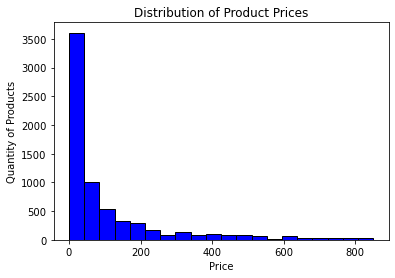

In [123]:
plt.hist(products['cleaned_price'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Price')
plt.ylabel('Quantity of Products')
plt.title('Distribution of Product Prices')
plt.show()

#### Numerically Encoding Location: 

Planning to split on comma in "location" column. Will use longitude/lattitude. To reduce variance in longitude/lattitude I'll use the major City/Couty. In other words: I'll use the location that follows the comma. If none is present, then I'll use the first county/city. As I removed NULL entries earlier, I know in each row of "location_info", there is always atleast a Major City or a Town listed.


This assumes that prices similar within each major city. If model performs poorly, this could be one improvement.

In [124]:
location_info = products['location'].str.split(',', expand=True)
location_info.head()

,0,1
0,Wokingham,Berkshire
1,Inverness,Highland
2,Skegness,Lincolnshire
3,Radstock,Somerset
4,Delph,Manchester


In [125]:
location_info.columns = ['Town', 'City']
town_counter, city_counter = Counter(location_info['Town']), Counter(location_info['City'])
location_info.shape

(6810, 2)

In [126]:
location_info.head()

,Town,City
0,Wokingham,Berkshire
1,Inverness,Highland
2,Skegness,Lincolnshire
3,Radstock,Somerset
4,Delph,Manchester


In [127]:
location_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6810 entries, 0 to 7155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Town    6810 non-null   object
 1   City    6574 non-null   object
dtypes: object(2)
memory usage: 159.6+ KB


Using one hot encoding for categories with many levels, can lead to large dimensionality within our data. We know that this leads to needing more computational power. Note of things we can do: 

- Use only most frequent categories. Take top 'x', where x can be determined by a frequency distribution. ie: take the top 'x' such that 80% of the data is accounted for. 
- Use a "Frequency Counts" method, involves replacing the category with its frequency. Negatives of this is that categories with similar counts will be treated alike, so may lose information. 
- Location data can be encoded using longitude and lattitude. 

Cleaning Location Data: Will use longitude/lattitude to encode location:

In [128]:
location_encoding = pd.DataFrame(products['location'])
location_encoding.head()

,location
0,"Wokingham, Berkshire"
1,"Inverness, Highland"
2,"Skegness, Lincolnshire"
3,"Radstock, Somerset"
4,"Delph, Manchester"


Testing extracting longitude and latitude from location.

In [129]:
geolocator = Nominatim(user_agent='my_user_agent')
loc_1 = location_encoding.iloc[1,0]
loc = geolocator.geocode(loc_1)
print(loc_1)
print(loc.latitude)
print(loc.longitude)

Inverness, Highland
57.4790124
-4.225739


In [130]:
locations_stored = {}

def _location_extractor(x : str) -> Tuple[float, float]:
    # Split location based on comma. 
    location_list = x.split(',')
    # If we only have one city/town then use that, else use the major city. 
    if len(location_list) == 1:
        city = location_list[0]
    else:
        city = location_list[1]
    try: 
        try:
            latitude, longitude = locations_stored[city]
            return latitude, longitude
        except:
            coords = geolocator.geocode(city)
            latitude, longitude = coords.latitude, coords.longitude
            locations_stored[city] = [latitude, longitude]
            return latitude, longitude
    except: 
        print(f'For {x}, cant use Gelocator')

In [131]:
products['latitude'], products['longitude'] = list(zip(*products['location'].apply(_location_extractor)))

In [132]:
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price,latitude,longitude
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gumtree","Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments","Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0,51.453489,-1.031873
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, Highland | Gumtree",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0,57.506636,-5.003837
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gumtree",Home & Garden / Garden & Patio / Outdoor Settings & Furniture,I have 2 of these - collection only as I don’t drive. £20 Ono,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0,53.182303,-0.203121
3,59948726-29be-4b35-ade5-bb2fd7331856,"Coffee side table from Ammunition ammo box hairpin legs | in Radstock, Somerset | Gumtree","Home & Garden / Dining, Living Room Furniture / Other","Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...",£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0,51.161751,-3.075387
4,16dbc860-696e-4cda-93f6-4dd4926573fb,"Modern Shannon Sofa for sale at low cost | in Delph, Manchester | Gumtree","Home & Garden / Dining, Living Room Furniture / Sofas, Armchairs & Suites / Private",New Design Shannon Corner sofa 5 Seater Available\r👉 Factory Sell Price\r👉New Amazing Design\r ...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0,53.479489,-2.245115


### Expanding Categories: 

We notice that following each forward slash there's another category. Using all subsequent categories may not be the smartest idea as this can lead to a large number of features, each with a small sample size. Let's explore further:

In [133]:
unclean_categories = products['category'].str.split(r'/', expand=True)

In [134]:
unclean_categories.shape
unclean_categories.head()

,0,1,2,3,4
0,Home & Garden,"Dining, Living Room Furniture","Mirrors, Clocks & Ornaments",None,None
1,Home & Garden,Other Household Goods,None,None,None
2,Home & Garden,Garden & Patio,Outdoor Settings & Furniture,None,None
3,Home & Garden,"Dining, Living Room Furniture",Other,None,None
4,Home & Garden,"Dining, Living Room Furniture","Sofas, Armchairs & Suites",Private,None


Nulls in table?

In [135]:
unclean_categories.isna().sum(axis=0)

0       0
1       0
2    2552
3    6272
4    6802
dtype: int64

I'll denote each category within the category hierachy by a column index. We see that for all of our datapoints we have categories at cols = 0 and cols = 1. Moving across the columns, the data becomes less available and practically NULL at col_index = 4. So I'll split the first and second indexxes. 

Lets get an idea of distribution of each major and minor category:

In [136]:
major_minor_categories = unclean_categories.iloc[:, 0:2]

In [137]:
major_minor_categories.columns = ['major', 'minor']
major_minor_categories.head()

,major,minor
0,Home & Garden,"Dining, Living Room Furniture"
1,Home & Garden,Other Household Goods
2,Home & Garden,Garden & Patio
3,Home & Garden,"Dining, Living Room Furniture"
4,Home & Garden,"Dining, Living Room Furniture"


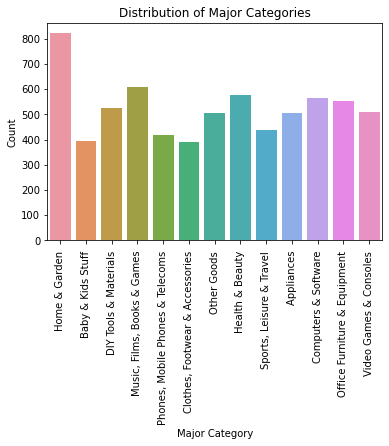

In [138]:
sns.countplot(x='major', data=major_minor_categories)
plt.xticks(rotation=90)
plt.xlabel('Major Category')
plt.ylabel('Count')
plt.title('Distribution of Major Categories')
plt.show()

Based on the even distribution and our overall objective, it seems logical to create a model to predict the major category

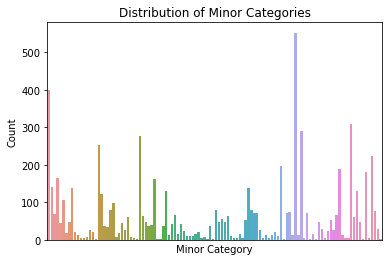

In [139]:
sns.countplot(x='minor', data=major_minor_categories)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('Minor Category')
plt.ylabel('Count')
plt.title('Distribution of Minor Categories')
plt.show()

Based on the distribution of the minor categories, I believe it's unwise to use them as features. Typically to use categorical data as features, we want only a few possible outcomes.

Adding in major_category column to products dataframe:

In [140]:
products['major_cat'] = products['category'].str.split(r'/', expand=True).iloc[:, 0]

In [141]:
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price,latitude,longitude,major_cat
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gumtree","Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments","Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0,51.453489,-1.031873,Home & Garden
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, Highland | Gumtree",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0,57.506636,-5.003837,Home & Garden
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gumtree",Home & Garden / Garden & Patio / Outdoor Settings & Furniture,I have 2 of these - collection only as I don’t drive. £20 Ono,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0,53.182303,-0.203121,Home & Garden
3,59948726-29be-4b35-ade5-bb2fd7331856,"Coffee side table from Ammunition ammo box hairpin legs | in Radstock, Somerset | Gumtree","Home & Garden / Dining, Living Room Furniture / Other","Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...",£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0,51.161751,-3.075387,Home & Garden
4,16dbc860-696e-4cda-93f6-4dd4926573fb,"Modern Shannon Sofa for sale at low cost | in Delph, Manchester | Gumtree","Home & Garden / Dining, Living Room Furniture / Sofas, Armchairs & Suites / Private",New Design Shannon Corner sofa 5 Seater Available\r👉 Factory Sell Price\r👉New Amazing Design\r ...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0,53.479489,-2.245115,Home & Garden


### NLP:

Processing Product Names, and product descriptions:

Let's preview some random product names:

In [142]:
rand_10 = random.sample(range(0, products.shape[0]-1), 10)

In [150]:
products.reset_index(inplace=True, drop=True)

In [152]:
products['product_name'][rand_10]

3207                                        Bosch drum belt pulley | in Cambridge, Cambridgeshire | Gumtree
1703                                          Biodegradable Wax Melts | in West Pilton, Edinburgh | Gumtree
3786               Learn with Paddington by Michael Bond (Hardback Book) | in Preston, Lancashire | Gumtree
5374                                      ESTEE Lauder make up set | in Coalville, Leicestershire | Gumtree
3217    HOOVER DYNAMIC NEXT 8KG A+++ WASHING MACHINE - 1600RPM SPIN - GOOD CONDITION - DELIVERY POSSIBLE...
1592    Joules Womens Mary King fleece lined waterproof size 10 IMMACULATE | in Poringland, Norfolk | Gu...
5697                            Professional Hair Dryers for women 2200W AC | in Victoria, London | Gumtree
1043                                           Nappy Destash | in Dumfries, Dumfries and Galloway | Gumtree
1519    Selling lots of womens clothing items; jumpers, coats, jeans, tops, shoes and more! | in Whaley ...
6649            PlayStation 

From initial observation it seems we can split the product names on the Pipe (|) and use only the first component as the data after first pipe is location which is already encoded.

In [153]:
product_name_split = products['product_name'].str.split('|', expand=True)
product_name_split.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Mirror wall art,"in Wokingham, Berkshire",Gumtree,None,None,None,None,None,None,None,None,None,None,None,None
1,Stainless Steel Food Steamer,"in Inverness, Highland",Gumtree,None,None,None,None,None,None,None,None,None,None,None,None
2,Sun loungers,"in Skegness, Lincolnshire",Gumtree,None,None,None,None,None,None,None,None,None,None,None,None
3,Coffee side table from Ammunition ammo box hairpin legs,"in Radstock, Somerset",Gumtree,None,None,None,None,None,None,None,None,None,None,None,None
4,Modern Shannon Sofa for sale at low cost,"in Delph, Manchester",Gumtree,None,None,None,None,None,None,None,None,None,None,None,None


In [154]:
product_name_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6810 non-null   object
 1   1       6810 non-null   object
 2   2       6810 non-null   object
 3   3       21 non-null     object
 4   4       15 non-null     object
 5   5       3 non-null      object
 6   6       2 non-null      object
 7   7       2 non-null      object
 8   8       1 non-null      object
 9   9       1 non-null      object
 10  10      1 non-null      object
 11  11      1 non-null      object
 12  12      1 non-null      object
 13  13      1 non-null      object
 14  14      1 non-null      object
dtypes: object(15)
memory usage: 798.2+ KB


Mostly NULL/repeated data values apart from first column. 

In [155]:
product_names = products['product_name'].str.split('|', expand=True)[0]

In [156]:
product_names.head(20)

0                                                                                        Mirror wall art 
1                                                                           Stainless Steel Food Steamer 
2                                                                                           Sun loungers 
3                                                Coffee side table from Ammunition ammo box hairpin legs 
4                                                               Modern Shannon Sofa for sale at low cost 
5                                                                                             Spotlights 
6         💥💥White Wardrobe💥💥Brand new Wardrobe For sale in Black/White/Grey Colour **Mirrored Wardrobe** 
7                                                                                            Letter cage 
8                                                                                  Double Pine Bed Frame 
9                                             

In [108]:
products['product_description'].head()

0    Mirror wall art. Posted by Nisha in Dining, Living Room Furniture, Mirrors, Clocks & Ornaments i...
1    Morphy Richard’s (model no 48755)Stainless steel 3 tier stackable food steamer9 litre capacity 1...
2                                         I have 2 of these - collection only as I don’t drive. £20 Ono 
3    Great reclaimed army ammunition box used as coffee side table\rOriginal text detail, latch's, le...
4    New Design Shannon Corner sofa  5 Seater Available\r👉 Factory Sell Price\r👉New Amazing Design\r ...
Name: product_description, dtype: object

Based on the above, I'll plan to use a TFIDF vectorizer on the product names and not use the product description at all yet. The product description seems very similar to the product name so may just be extra noise.

## Final Dataset:
 
#### Implementations:
- Drop rows with NULL
- Clean Price: Check that price is in pounds as model is being trained on pounds. 
- Numerically encode the city into longitude and latitude.
- Use a TFIDF vectorizer to extract features from product_name.  
- Split Category column so the major_category is our output. 


#### Features in cleaned dataset:
- Price
- Longitude and latitude of location. 
- Feature vector from Vectorizer. 
- Labels for data is the major_category. 


### Things to Improve Model: 
- Extract more features from product description. 
- Impute/fill missing values to increase data and hence reduce overfitting. 
- Use minor category.